# Energy Consumption Forecast

Table of Contents:

1. Data Analysis
    - Data Description
    - Data Loading
    - Exploratory Data Analysis (EDA)
        - Correlation Heatmap
        - Relationship between variables
        - Scatter-matrix
        - Distribution Plots
        - Box Plots
        - Count Plots
    - Data Preprocessing
2. Machine Learning
    - Model Selection
    - Hyperparameter tuning
3. Conclusions

**Problem Statement**: The volatile energy market is unsure of future energy consumption. Departments of Energy Need expert opinion on the future demand of electrical energy in the Eastern part of the US.

**Objective**: Train a Machine Learning Model to predict energy consumption in the future based on current data. Backtest the model.

## Data Description

Source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

The data has 145366 entries for energy consumption of the Eastern part of the US as handled by PJM (PJM Interconnection LLC), a regional transmission organization coordinating the transfer of electricity across multiple power grids in America. The columns in this dataset are:

- Datetime (hourly from December 2002 to February 2018)
- PJME_MW (Current reading of energy transfered per unit of time in Megawatts)

In [100]:
#Loading libraries and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.color_palette("tab10")
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb

In [101]:
data = pd.read_csv('PJME_hourly.csv')
data

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [103]:
#Check for null values
data.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

In [104]:
#Check for duplicates
data.duplicated().sum()

0

In [105]:
#Reindexing data by date
data.set_index('Datetime')

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [106]:
#Changing object type
data['Datetime'] = pd.to_datetime(data['Datetime'] )

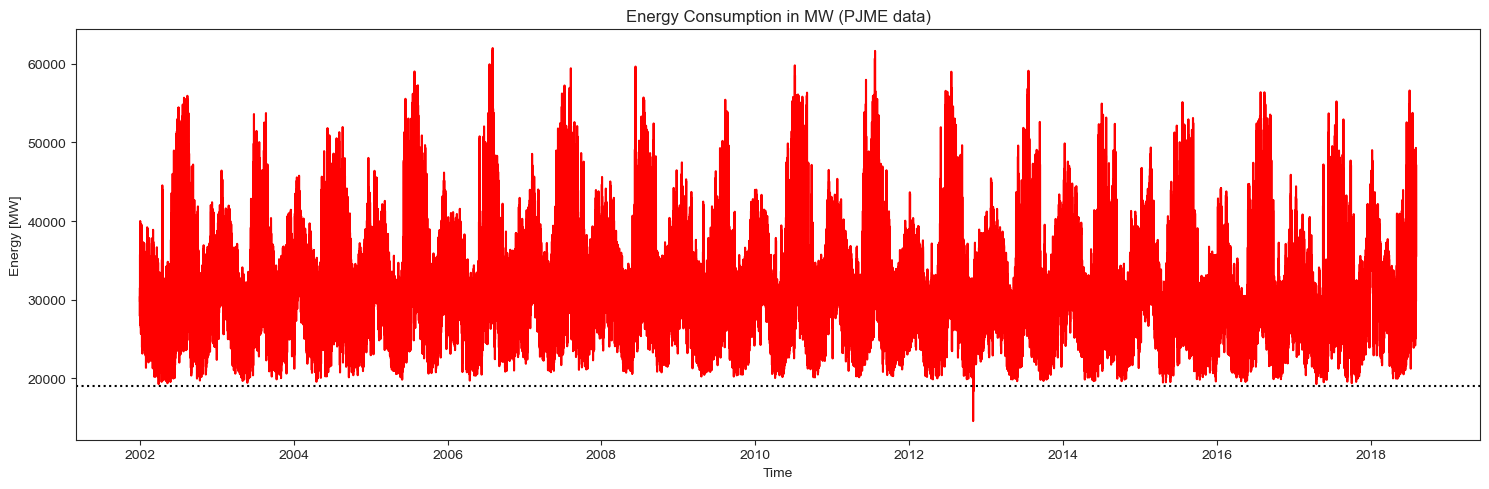

In [107]:
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data, x='Datetime', y='PJME_MW', color='r')
plt.axhline(19_000, ls='dotted', color='k')
plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTimeOutliers.png', bbox_inches='tight')
plt.show()

Around the year 2013, the data shows an anomalous dip in energy consumption well below 15000 MW. This seems unreasonable and is likely an error in the data. Such data needs to be removed in order that our predictive model performs better by not training on anomalous data.

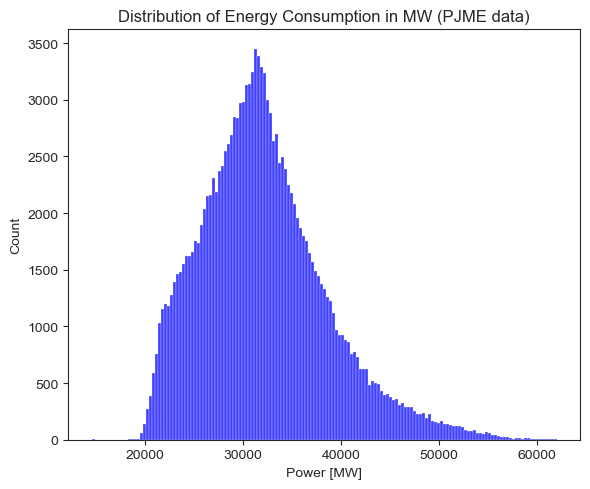

In [108]:
#Distribution Plot for energy consumption (with outliers)
fig = plt.figure(figsize=(6,5))
sns.histplot(data=data, x='PJME_MW', color='b')
plt.title('Distribution of Energy Consumption in MW (PJME data)')
plt.xlabel('Power [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyDistributionOutlier.png', bbox_inches='tight')
plt.show()

In [109]:
#Removing outliers (below 19,000 MW)
data = data[data['PJME_MW'] >= 19000]

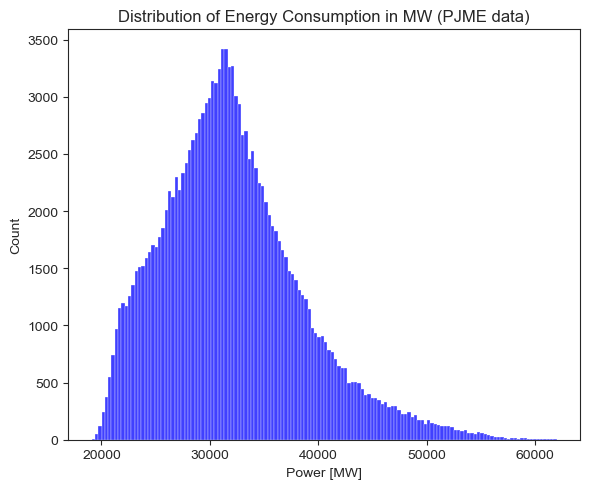

In [110]:
#Distribution Plot for energy consumption (outliers removed)
fig = plt.figure(figsize=(6,5))
sns.histplot(data=data, x='PJME_MW', color='b')
plt.title('Distribution of Energy Consumption in MW (PJME data)')
plt.xlabel('Power [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyDistributionFixed.png', bbox_inches='tight')
plt.show()

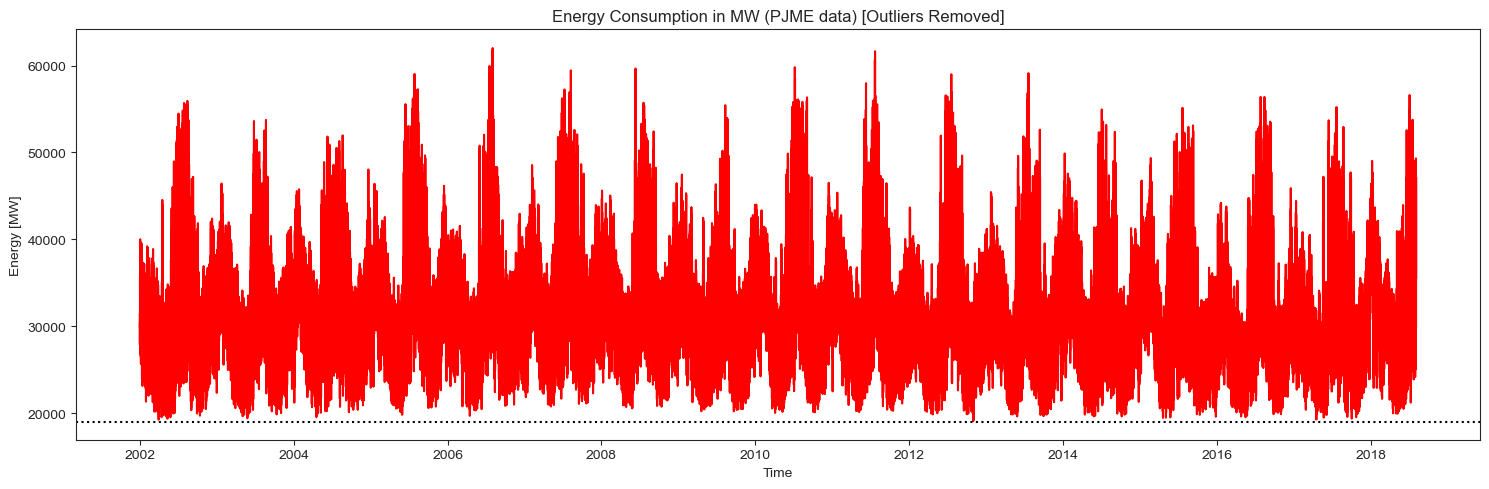

In [111]:
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data, x='Datetime', y='PJME_MW', color='r')
plt.axhline(19_000, ls='dotted', color='k')
plt.title('Energy Consumption in MW (PJME data) [Outliers Removed]')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTimeFixed.png', bbox_inches='tight')
plt.show()

For training our model, we will use 80% of all data. This means that data from 2002 to 2015 will be used for training, while we will use the remaining data for cross-validation and testing. When using a cross-validation set for building our time-series predictive model, it is imperative that the test data is at a later point in time than the train data. Doing cross-validation otherwise would result in data leakage that would give us a false impression of our model being better than it actually is.

In [99]:
#Initializing a TimeSeriesSplit generator for time-series cross-validation
time_ser_split = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
data = data.sort_values('Datetime') #data need to be sorted in respect to time beforehand
data.set_index(data['Datetime'], inplace=True)
data.drop(data['Datetime'], inplace=True)
data.sort_index()
data

ValueError: 'Datetime' is both an index level and a column label, which is ambiguous.

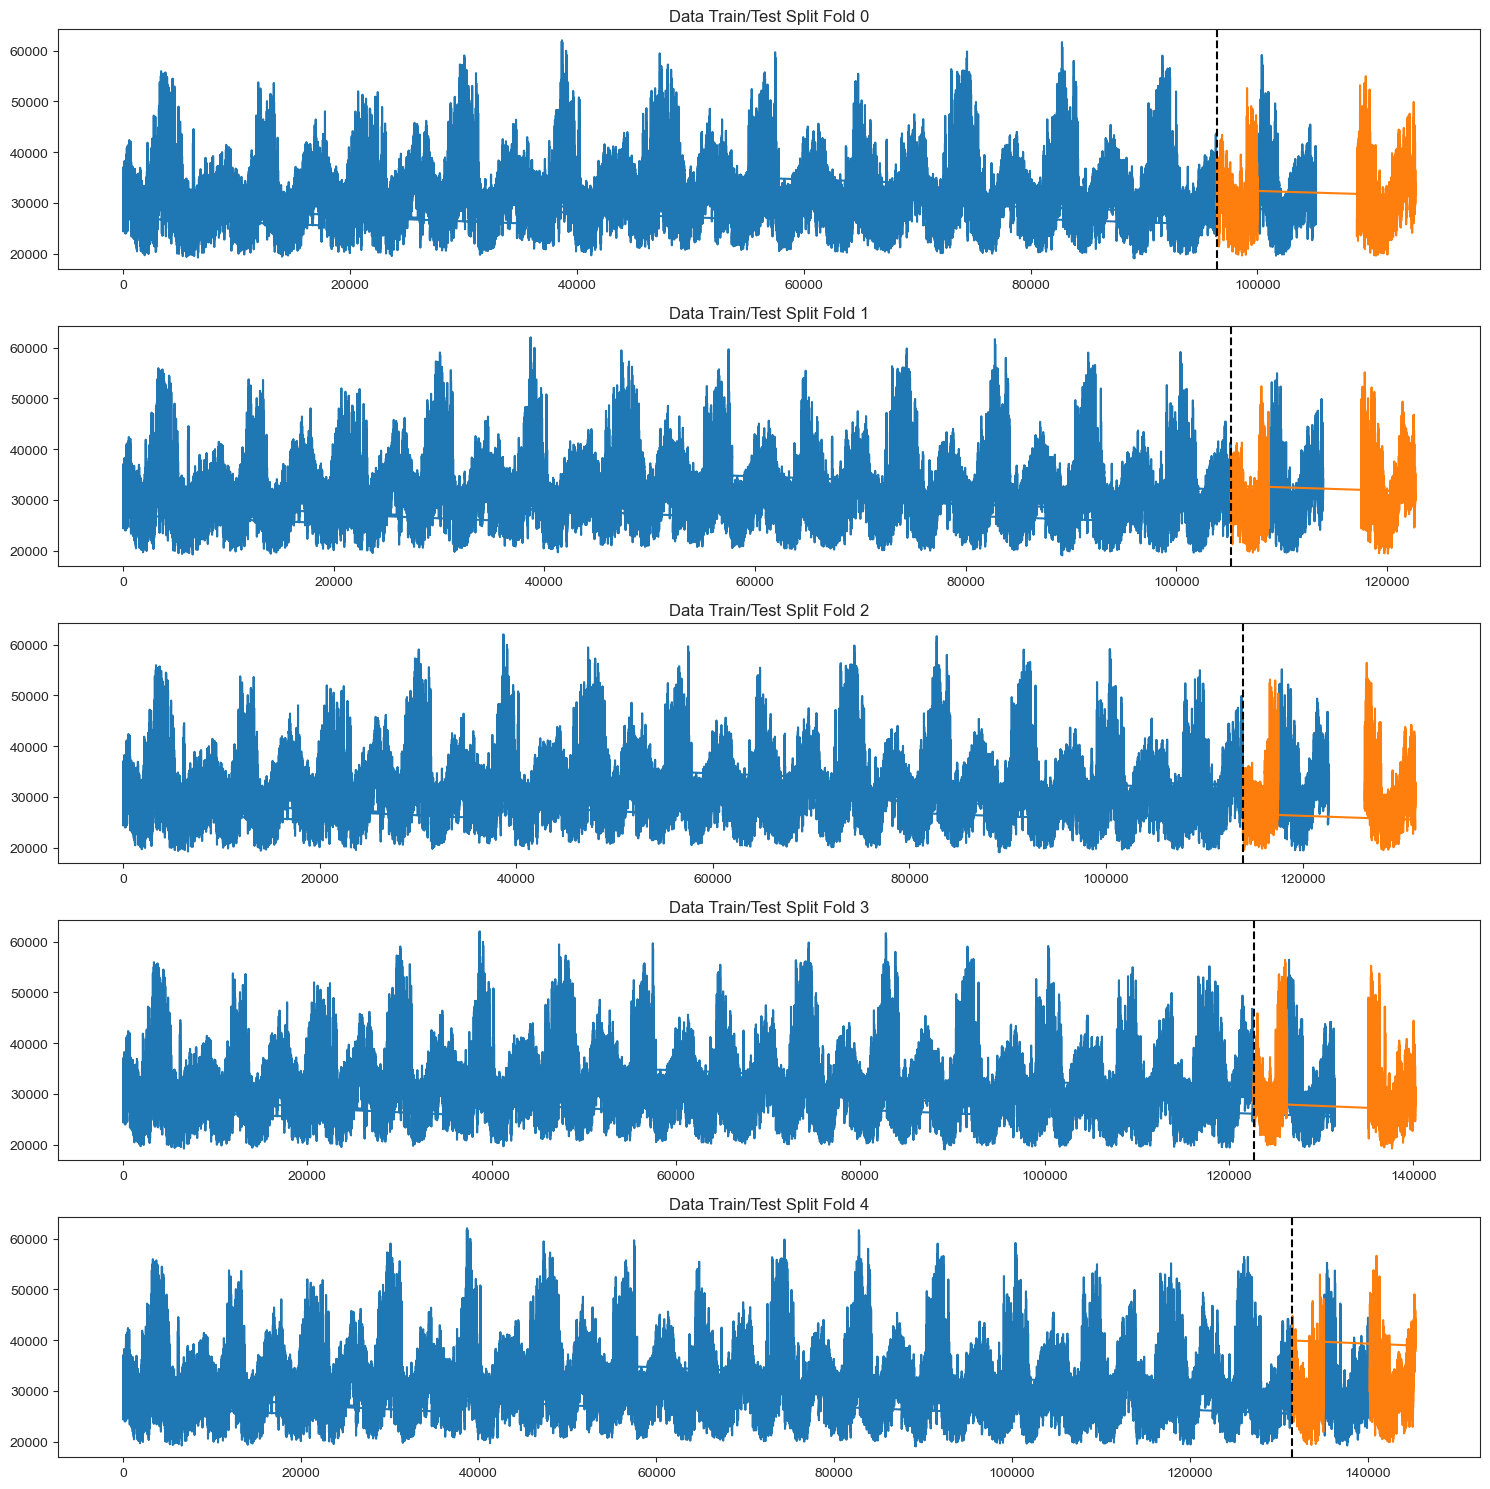

In [ ]:
#Visualizing this time-series cross-validation procedure
fig, ax = plt.subplots(5, 1, figsize=(15,15))

fold = 0
for train_index, test_index in time_ser_split.split(data):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    train['PJME_MW'].plot(ax=ax[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=ax[fold], label='Test Set')
    ax[fold].axvline(test.index.min(), color='k', ls='--')
    fold += 1

plt.tight_layout()
plt.savefig('images/01_TimeSeriesSplit.png', bbox_inches='tight')
plt.show()

In [ ]:
train = data[data['Datetime'] < '01-01-2015']
test = data.loc[data['Datetime'] >= '01-01-2015']

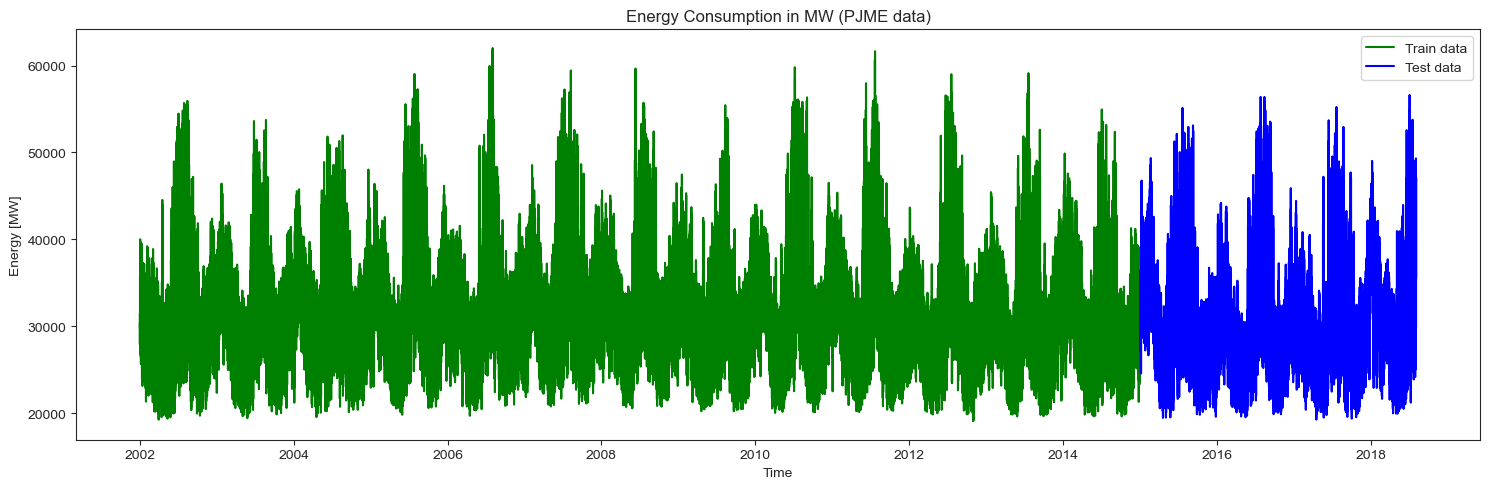

In [ ]:
#Plotting train and test data
import matplotlib.lines as mlines

fig = plt.figure(figsize=(15,5))
sns.lineplot(data=train, x='Datetime', y='PJME_MW', color='g')
sns.lineplot(data=test, x='Datetime', y='PJME_MW', color='b')

plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')

train_label = mlines.Line2D([], [], color='green', ls='-', label='Train data')
test_label = mlines.Line2D([], [], color='blue', ls='-', label='Test data')
plt.legend(handles=[train_label, test_label])

plt.tight_layout()
plt.savefig('images/02_EnergyTimeTrainTest.png', bbox_inches='tight')
plt.show()

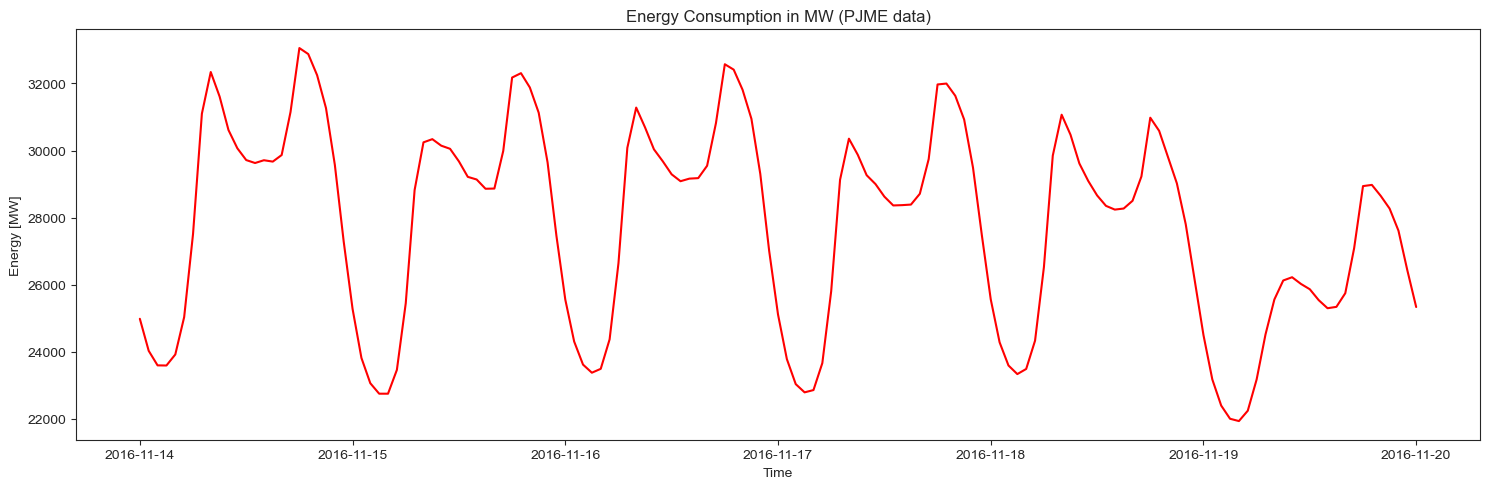

In [ ]:
#Plotting weekly data
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data[(data['Datetime'] >=  '11-14-2016') & (data['Datetime'] <=  '11-20-2016')], x='Datetime', y='PJME_MW', color='r')
plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTimeWeekly.png', bbox_inches='tight')
plt.show()

Weekly data indicates that total energy consumption is actually lower on weekends (Saturdays and especially Sundays). This is likely due to the fact that the weekends are rest days for most workers. The absence of work that requires electrical power, when aggregated across various work sectors, creates noticeable relief for the power grid.

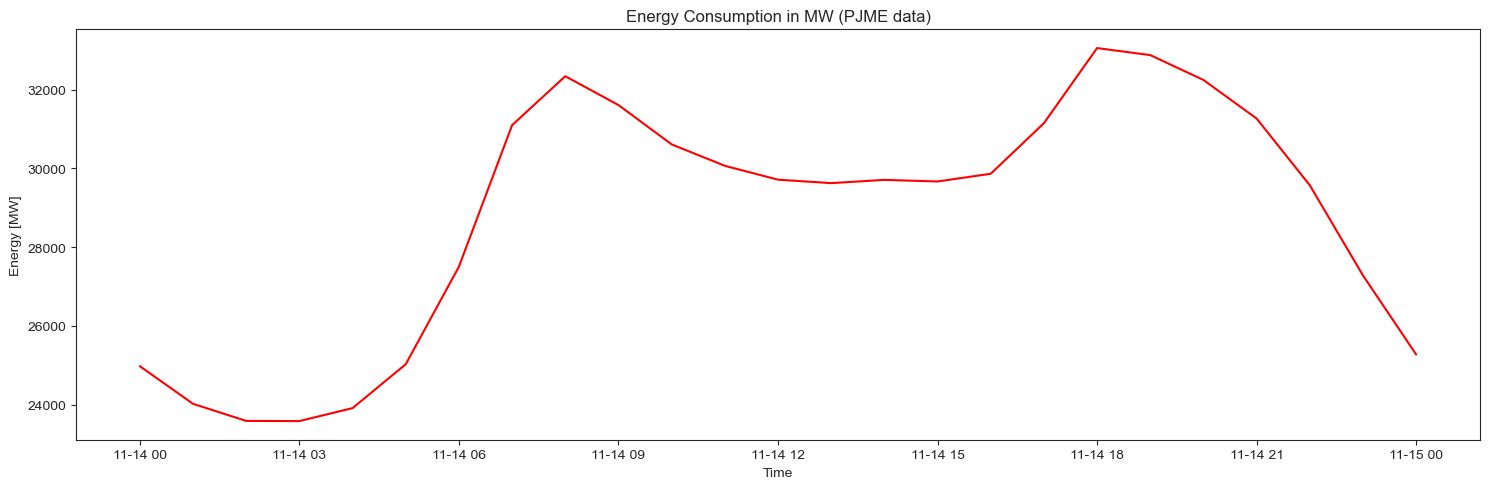

In [ ]:
#Plotting daily data
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=data[(data['Datetime'] >=  '2016-11-14 00:00:00') & (data['Datetime'] <=  '2016-11-15 00:00:00')], x='Datetime', y='PJME_MW', color='r')
plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')
plt.tight_layout()
plt.savefig('images/01_EnergyTimeDaily.png', bbox_inches='tight')
plt.show()

Daily energy consumption data is telling of the fact that energy consumption peaks around 8 a.m. in the morning, regresses back to a lower level, and then peaks at around 6 p.m. in the evening, after which it decreases to a relatively low level. This kind of pattern in energy consumption is perfectly understandable when considering the daily cycle of an average citizen: sleep, waking up and work, rest, dinner and diversion, and all around again.

In [ ]:
#Creating features for our ML model based on time series data
def create_features(df):
    data = df.copy()
    data["Year"] = data['Datetime'].dt.year
    data["Quarter"] = data['Datetime'].dt.quarter
    data["Day_of_year"] = data['Datetime'].dt.dayofyear
    data["Month"] = data['Datetime'].dt.month
    data["Day_of_week"] = data['Datetime'].dt.dayofweek
    data["Hour"] = data['Datetime'].dt.hour
    return data

data = create_features(data)
data.set_index('Datetime')

,PJME_MW,Year,Quarter,Day_of_year,Month,Day_of_week,Hour
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,2002,4,365,12,1,1
2002-12-31 02:00:00,25147.0,2002,4,365,12,1,2
2002-12-31 03:00:00,24574.0,2002,4,365,12,1,3
2002-12-31 04:00:00,24393.0,2002,4,365,12,1,4
2002-12-31 05:00:00,24860.0,2002,4,365,12,1,5
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,2018,1,1,1,0,20
2018-01-01 21:00:00,43751.0,2018,1,1,1,0,21
2018-01-01 22:00:00,42402.0,2018,1,1,1,0,22


In [ ]:
data

,Datetime,PJME_MW,Year,Quarter,Day_of_year,Month,Day_of_week,Hour
0,2002-12-31 01:00:00,26498.0,2002,4,365,12,1,1
1,2002-12-31 02:00:00,25147.0,2002,4,365,12,1,2
2,2002-12-31 03:00:00,24574.0,2002,4,365,12,1,3
3,2002-12-31 04:00:00,24393.0,2002,4,365,12,1,4
4,2002-12-31 05:00:00,24860.0,2002,4,365,12,1,5
...,...,...,...,...,...,...,...,...
145361,2018-01-01 20:00:00,44284.0,2018,1,1,1,0,20
145362,2018-01-01 21:00:00,43751.0,2018,1,1,1,0,21
145363,2018-01-01 22:00:00,42402.0,2018,1,1,1,0,22
145364,2018-01-01 23:00:00,40164.0,2018,1,1,1,0,23


In [ ]:
#Removing outliers outside of the 0.05-0.95 quantile range for all numerical categories
def remove_outliers_percentile(df, numerical_columns):
    for i,col in enumerate(df[numerical_columns]):
        min_threshold = df[col].quantile(0.05)
        max_threshold = df[col].quantile(0.95)
        df = df[(df[col] <= max_threshold) & (df[col] >= min_threshold)]
    return df

data = remove_outliers_percentile(data, ['PJME_MW'])

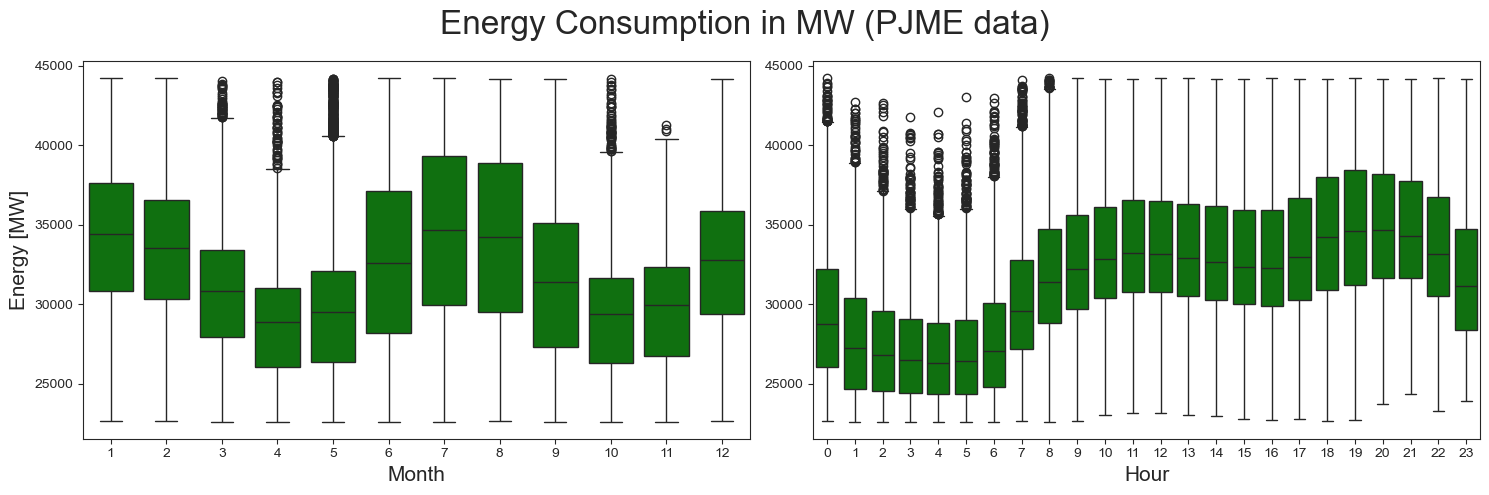

In [ ]:
#Box plots
fig, ax= plt.subplots(1,2, figsize=(15,5))
sns.boxplot(data=data, x='Month', y='PJME_MW', ax=ax[0], color='green')
sns.boxplot(data=data, x='Hour', y='PJME_MW', ax=ax[1], color='green')
plt.suptitle('Energy Consumption in MW (PJME data)', fontsize=24)

ax[0].set_xlabel("Month", fontsize= 15)
ax[1].set_xlabel("Hour", fontsize= 15)

ax[0].set_ylabel('Energy [MW]', fontsize= 15)
ax[1].set_ylabel('')

plt.tight_layout()
plt.savefig('images/01_EnergyTimeBoxplot.png', bbox_inches='tight')
plt.show()

We repeat our conclusions regarding the variations in energy consumption across the hours of the day. Monthly time-series data shows that energy consumption peaks most prominently in the summer months, when cooling devices are in use, and also in the winter months, when heating devices are usually under load. The transitory periods of spring and autumn are not as heavy in regards to the expenditure of electrical energy.

In [ ]:
#Creating train and test feature and target matrices
train = create_features(train)
test = create_features(test)

X_train = train.drop('PJME_MW', axis='columns').set_index('Datetime')
Y_train = train['PJME_MW']

X_test = test.drop('PJME_MW', axis='columns').set_index('Datetime')
Y_test= test['PJME_MW']

In [ ]:
#XGBRegressor Model
XGB_reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=70, learning_rate=0.005)
XGB_reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=25)

[0]	validation_0-rmse:6427.72554	validation_1-rmse:6501.06632
[25]	validation_0-rmse:5911.02716	validation_1-rmse:6028.85620
[50]	validation_0-rmse:5469.41917	validation_1-rmse:5633.60541
[75]	validation_0-rmse:5092.75625	validation_1-rmse:5302.07375
[100]	validation_0-rmse:4775.12826	validation_1-rmse:5025.49191
[125]	validation_0-rmse:4502.60201	validation_1-rmse:4797.46144
[150]	validation_0-rmse:4273.22681	validation_1-rmse:4607.85360
[175]	validation_0-rmse:4080.45347	validation_1-rmse:4449.74479
[200]	validation_0-rmse:3919.27612	validation_1-rmse:4319.51593
[225]	validation_0-rmse:3780.16234	validation_1-rmse:4221.10751
[250]	validation_0-rmse:3665.35867	validation_1-rmse:4137.13376
[275]	validation_0-rmse:3565.15695	validation_1-rmse:4069.19642
[300]	validation_0-rmse:3480.52360	validation_1-rmse:4015.06924
[325]	validation_0-rmse:3408.95681	validation_1-rmse:3967.59851
[350]	validation_0-rmse:3346.93539	validation_1-rmse:3927.02845
[375]	validation_0-rmse:3294.06122	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=70,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

The left column represents the error cost of the training set, and the right column of the test set. While the training cost error is descending monotonous function, the test error has minimum that must not be passed; otherwise, our model would overfit. The sweet spot for this particular learning rate seems to be around 725 iterations:

In [ ]:
XGB_reg.best_iteration

730

<Figure size 1500x500 with 0 Axes>

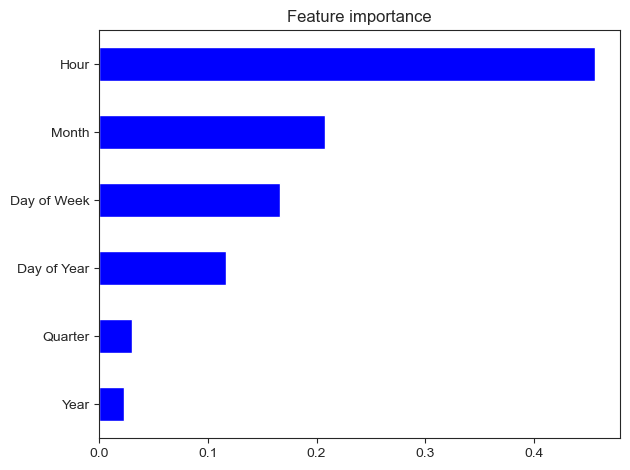

In [ ]:
#Plotting feature importances
feature_df = pd.DataFrame(data=XGB_reg.feature_importances_, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
fig = plt.figure(figsize=(15,5))
feature_df.plot(kind='barh', color='b').invert_yaxis()
plt.title('Feature importance')
plt.legend().remove()
plt.yticks(ticks=[0,1,2,3,4,5], labels=['Hour', 'Month', 'Day of Week', 'Day of Year', 'Quarter', 'Year'])

plt.tight_layout()
plt.savefig('images/01_FeatureImportance.png', bbox_inches='tight')
plt.show()

In [ ]:
#Testing our model on test data and seeing whether predictions match real data
test['prediction'] = XGB_reg.predict(X_test)

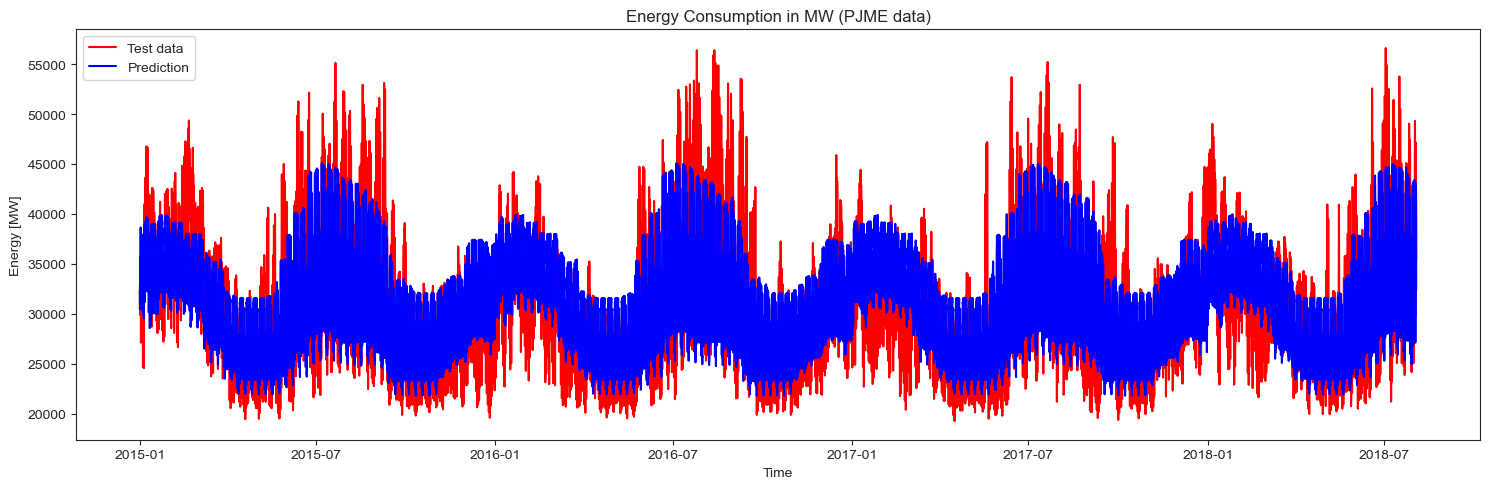

In [ ]:
#Plotting prediction VS real data
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=test, x='Datetime', y='PJME_MW', color='r')
sns.lineplot(data=test, x='Datetime', y='prediction', color='b')

plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')

train_label = mlines.Line2D([], [], color='r', ls='-', label='Test data')
test_label = mlines.Line2D([], [], color='b', ls='-', label='Prediction')

plt.legend(handles=[train_label, test_label])
plt.tight_layout()
plt.savefig('images/01_PredictionVSTest.png', bbox_inches='tight')
plt.show()

C:\Users\jom4n\AppData\Local\Temp\ipykernel_14516\3965136684.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=test[(test['Datetime'] >=  '11-14-2016') & (data['Datetime'] <=  '11-20-2016')], x='Datetime', y='PJME_MW', color='r')
C:\Users\jom4n\AppData\Local\Temp\ipykernel_14516\3965136684.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data=test[(test['Datetime'] >=  '11-14-2016') & (data['Datetime'] <=  '11-20-2016')], x='Datetime', y='prediction', color='b')


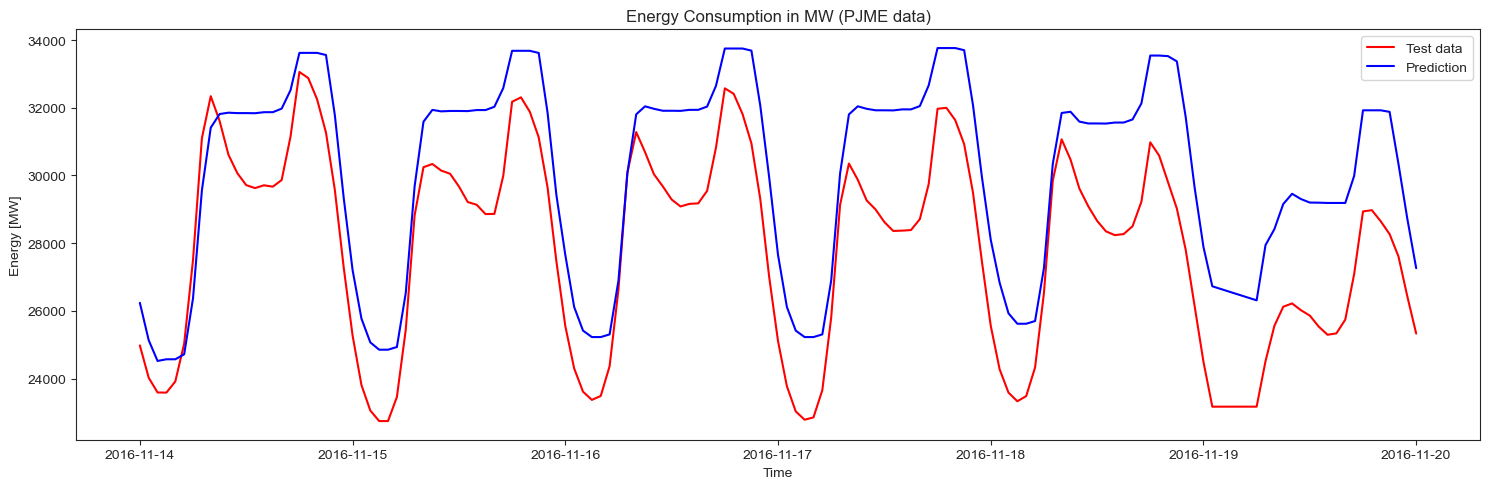

In [ ]:
#Plotting prediction VS real data (one week)
fig = plt.figure(figsize=(15,5))
sns.lineplot(data=test[(test['Datetime'] >=  '11-14-2016') & (data['Datetime'] <=  '11-20-2016')], x='Datetime', y='PJME_MW', color='r')
sns.lineplot(data=test[(test['Datetime'] >=  '11-14-2016') & (data['Datetime'] <=  '11-20-2016')], x='Datetime', y='prediction', color='b')

plt.title('Energy Consumption in MW (PJME data)')
plt.xlabel('Time')
plt.ylabel('Energy [MW]')

train_label = mlines.Line2D([], [], color='r', ls='-', label='Test data')
test_label = mlines.Line2D([], [], color='b', ls='-', label='Prediction')

plt.legend(handles=[train_label, test_label])
plt.tight_layout()
plt.savefig('images/01_PredictionVSTest.png', bbox_inches='tight')
plt.show()

The plots above show that the model successfully follows the overall shape of the test curve somewhat like a smoothened moving average. However, it lacks sufficient volatility and precision. To optimize our model further, we could focus on:
- Hyperparameter tuning
- Featuring engineering (adding features that indicate whether a day is a workday or holiday, and similar)

The error used in this exercise is the RMSE (Root Mean Squared Error). The reason for using this specific metric is that it penalizes large errors much more that it does relatively smaller ones. This is important for time-series predictions, as we want to follow the general trend and punish any blatant prediction mistakes.

In [ ]:
#Caluclating RMSE score 
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
score

3733.2674865025883

In [ ]:
#Calculating absolute error and querying for the dates with the 10 biggest prediction errors
test['error_abs'] = abs( test['prediction'] - test['PJME_MW'] )
test['date'] = test['Datetime'].dt.strftime('%m-%d')
errors_df = test.groupby('date')['error_abs'].mean().sort_values(ascending=False)
errors_df.head(10)

date
09-09    8745.467448
09-08    7059.862142
02-20    6895.568197
09-10    6565.747965
02-21    6500.469421
03-01    6192.610962
06-12    6044.651632
08-14    5961.105496
02-29    5699.639160
08-13    5579.326036
Name: error_abs, dtype: float64

The above table shows that, when averaged over the years from 2002 to 2018, the most error-prone dates are those in the month of September, as well as those of late February and early March. This is possibly because these seasonally transitory periods are exceptions to the time-series rule that the model has learned. In other words, as the graphs shown above clearly show, the trend in energy consumption during Fall and Spring is diminished in overall range, resulting in slight problems for the predictive model.

In [ ]:
test

,Datetime,PJME_MW,Year,Quarter,Day_of_year,Month,Day_of_week,Hour,prediction,error_abs,date
105190,2015-01-01 00:00:00,32802.0,2015,1,1,1,3,0,32329.195312,472.804688,01-01
113927,2015-12-31 01:00:00,24305.0,2015,4,365,12,3,1,28964.775391,4659.775391,12-31
113928,2015-12-31 02:00:00,23156.0,2015,4,365,12,3,2,27811.462891,4655.462891,12-31
113929,2015-12-31 03:00:00,22514.0,2015,4,365,12,3,3,27473.021484,4959.021484,12-31
113930,2015-12-31 04:00:00,22330.0,2015,4,365,12,3,4,27473.021484,5143.021484,12-31
...,...,...,...,...,...,...,...,...,...,...,...
145361,2018-01-01 20:00:00,44284.0,2018,1,1,1,0,20,38587.351562,5696.648438,01-01
145362,2018-01-01 21:00:00,43751.0,2018,1,1,1,0,21,38511.937500,5239.062500,01-01
145363,2018-01-01 22:00:00,42402.0,2018,1,1,1,0,22,36367.449219,6034.550781,01-01
145364,2018-01-01 23:00:00,40164.0,2018,1,1,1,0,23,35107.742188,5056.257812,01-01
